/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_71388/586179910.py:9: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')


     start_station_id  ride_count  start_lat  start_lng
0             2733.03          10  40.633385 -74.016562
1             2782.02           8  40.635679 -74.020005
2             2821.06          17  40.635928 -74.013256
3             2832.03          23  40.637033 -74.022141
4             2861.02           7  40.638566 -74.010147
...               ...         ...        ...        ...
4239          8879.03          66  40.885240 -73.900770
4240          8897.05          35  40.886020 -73.902320
4241           SYS016          49  40.709628 -73.931457
4242           SYS038           1  40.709306 -73.931175
4243     Shop Morgan           36  40.709873 -73.931594

[4244 rows x 4 columns] <class 'pandas.core.frame.DataFrame'>


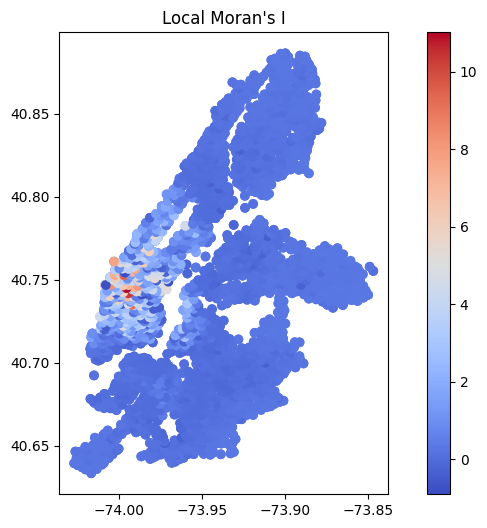

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')

# Aggregate data to calculate the number of rides for each station
station_counts = data.groupby('start_station_id').size().reset_index(name='ride_count')

# Get the geographical location of each station
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# Merge data
station_data = pd.merge(station_counts, station_locations, on='start_station_id')
print(station_data,type(station_data))
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data.start_lng, station_data.start_lat))

# Create weight matrix
w = weights.DistanceBand.from_dataframe(gdf, threshold=0.01, silence_warnings=True)

# Calculate Local Moran's I
local_moran = esda.Moran_Local(gdf['ride_count'], w)

# Add results to GeoDataFrame
gdf['local_moran'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='local_moran', cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I")
plt.savefig('./map/local_morans_i.png', dpi=300)
plt.show()

In [11]:
import folium

# Add results to GeoDataFrame
gdf['local_moran'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# Add significance level
gdf['significant'] = gdf['p_value'] < 0.05

# Classify
gdf['category'] = 'Not Significant'
gdf.loc[(gdf['local_moran'] > 0) & (gdf['significant']), 'category'] = 'HH'
gdf.loc[(gdf['local_moran'] < 0) & (gdf['significant']), 'category'] = 'LL'
gdf.loc[(gdf['local_moran'] > 0) & (~gdf['significant']), 'category'] = 'HL'
gdf.loc[(gdf['local_moran'] < 0) & (~gdf['significant']), 'category'] = 'LH'

# Define color mapping
color_map = {
    'HH': 'red',
    'LL': 'blue',
    'HL': 'yellow',
    'LH': 'green',
    'Not Significant': 'gray'
}

# Create map object
m = folium.Map(location=[gdf['start_lat'].mean(), gdf['start_lng'].mean()], zoom_start=13)

# Add station markers to the map
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=5,
        popup=f"{row['start_station_id']}: {row['category']}",
        color=color_map[row['category']],
        fill=True,
        fill_color=color_map[row['category']]
    ).add_to(m)

# Save map to file
m.save('./map/stations_local_moran_map.html')

/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_71388/3648962390.py:7: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')


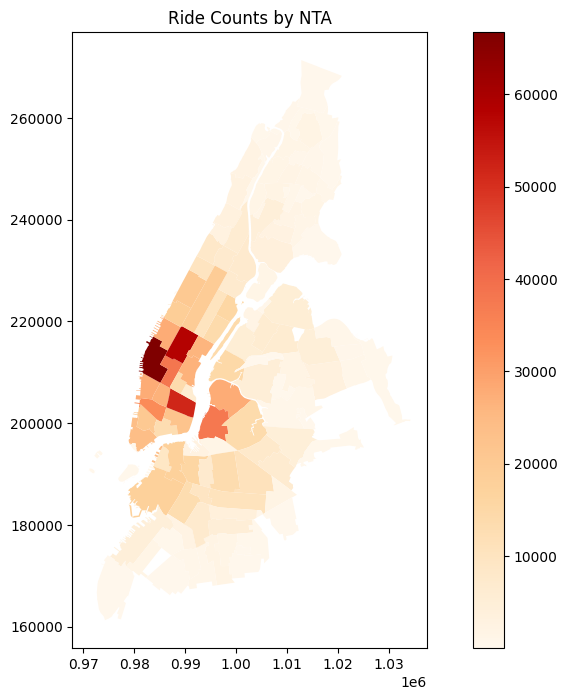

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')

# Aggregate data to calculate the number of rides for each station
station_counts = data.groupby('start_station_id').size().reset_index(name='ride_count')

# Get the geographical location of each station
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# Merge data
station_data = pd.merge(station_counts, station_locations, on='start_station_id')

# Create GeoDataFrame for stations
gdf_stations = gpd.GeoDataFrame(
    station_data, 
    geometry=gpd.points_from_xy(station_data.start_lng, station_data.start_lat),
    crs="EPSG:4326"  # Ensure using WGS 84 coordinate system
)

# Load NTA shapefile
nta_gdf = gpd.read_file('./nynta2020_24c/nynta2020.shp', driver='ESRI Shapefile')

# Transform station data to the NTA coordinate system
gdf_stations = gdf_stations.to_crs(nta_gdf.crs)

# Spatial join to assign NTA to each station
stations_with_nta = gpd.sjoin(gdf_stations, nta_gdf, how='left', predicate='intersects')

# Aggregate ride counts by NTA
nta_ride_counts = stations_with_nta.groupby('NTAName')['ride_count'].sum().reset_index()

# Merge with NTA GeoDataFrame for visualization
nta_gdf = nta_gdf.merge(nta_ride_counts, on='NTAName', how='left')

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
nta_gdf.plot(column='ride_count', cmap='OrRd', legend=True, ax=ax)
plt.title("Ride Counts by NTA")
plt.savefig('./map/ride_counts_by_nta.png', dpi=300)
plt.show()


In [3]:
print(gdf_stations.crs)
print(nta_gdf.crs)

EPSG:2263
EPSG:2263


/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_71388/747265713.py:8: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')
/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_71388/747265713.py:45: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(nta_gdf)
/Users/jiazhuangfeng/Documents/project/spatial_analysis/venv/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 3 islands with ids: 104, 161, 259.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 104, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 259, ' is an island (no neighbors)')


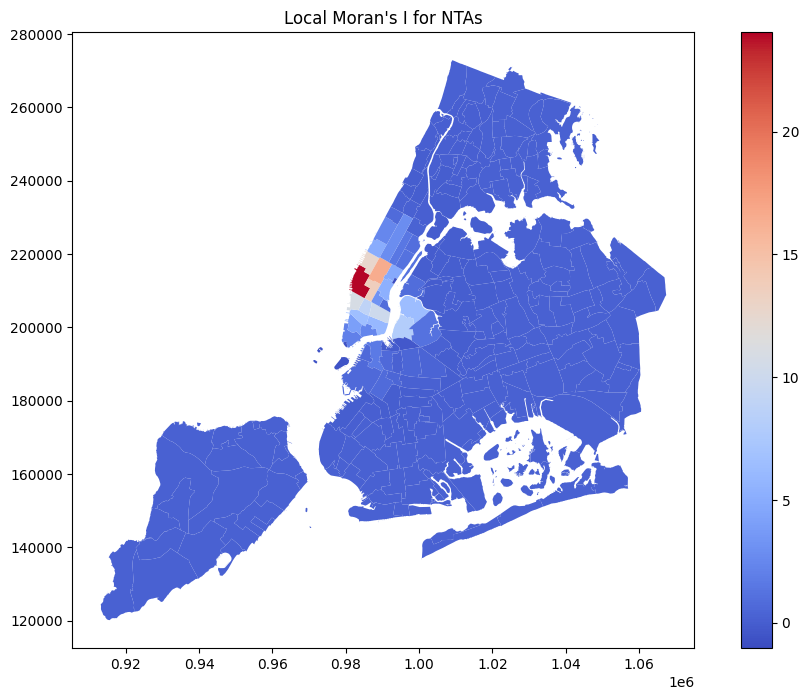

In [13]:
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')

# Aggregate data to calculate the number of rides for each station
station_counts = data.groupby('start_station_id').size().reset_index(name='ride_count')

# Get the geographical location of each station
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# Merge data
station_data = pd.merge(station_counts, station_locations, on='start_station_id')

# Create GeoDataFrame for stations
gdf_stations = gpd.GeoDataFrame(
    station_data, 
    geometry=gpd.points_from_xy(station_data.start_lng, station_data.start_lat),
    crs="EPSG:4326"
)

# Load NTA shapefile
nta_gdf = gpd.read_file('./nynta2020_24c/nynta2020.shp', driver='ESRI Shapefile')

# Transform station data to the NTA coordinate system
gdf_stations = gdf_stations.to_crs(nta_gdf.crs)

# Spatial join to assign NTA to each station
stations_with_nta = gpd.sjoin(gdf_stations, nta_gdf, how='left', predicate='intersects')

# Aggregate ride counts by NTA
nta_ride_counts = stations_with_nta.groupby('NTAName')['ride_count'].sum().reset_index()

# Merge with NTA GeoDataFrame
nta_gdf = nta_gdf.merge(nta_ride_counts, on='NTAName', how='left')

# Fill NaN values with 0 for ride counts
nta_gdf['ride_count'] = nta_gdf['ride_count'].fillna(0)

# Create spatial weights matrix for NTAs
w = weights.Queen.from_dataframe(nta_gdf)

# Calculate Local Moran's I
local_moran = esda.Moran_Local(nta_gdf['ride_count'], w)

# Add results to GeoDataFrame
nta_gdf['local_moran'] = local_moran.Is
nta_gdf['p_value'] = local_moran.p_sim

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
nta_gdf.plot(column='local_moran', cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I for NTAs")
plt.savefig('./map/local_morans_i_nta.png', dpi=300)
plt.show()
